In [1]:
# -*- coding: utf-8 -*-
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt

/Users/zhangyanming/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
class1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware'];
class2 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'];
class1_train = fetch_20newsgroups(subset = 'train', categories = class1, shuffle=True, random_state=42, remove=('headers','footers','quotes'));
class2_train = fetch_20newsgroups(subset = 'train', categories = class2, shuffle=True, random_state=42, remove=('headers','footers','quotes'));

## Problem 1)

In [3]:
from sklearn.feature_extraction import text
import re
import nltk 
import string
import numpy as np
from sklearn.feature_extraction import text

In [4]:
stop_words = text.ENGLISH_STOP_WORDS

from nltk.stem.snowball import SnowballStemmer
from nltk.tag import pos_tag
stemmer = SnowballStemmer("english")

def tokenizer_fun(text):
    new_text = re.sub(r'[^A-Za-z]', " ", text)
    new_text = re.sub("[,.-:/()?{}*$#&]"," ",new_text)  # remove all symbols
    new_text = "".join([ch for ch in new_text if ch not in string.punctuation])  # remove all punctuation
    new_text = "".join(ch for ch in new_text if ord(ch) < 128)  # remove all non-ascii characters
    new_text = new_text.lower() # convert to lowercase
    tokens =[word for sent in nltk.sent_tokenize(new_text) for word in nltk.word_tokenize(sent)]
    new_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]{2,}', token):
            new_tokens.append(token)     
    stem = [stemmer.stem(t) for t in new_tokens]
    tagged_sent = pos_tag(stem)
    new_stem = [word for word,pos in tagged_sent if pos == 'NN'] # remove all non-noun words
    return new_stem

In [14]:
from sklearn.datasets import fetch_20newsgroups
# total_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, categories = class1+class2, remove=('headers','footers','quotes'))
# total_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, categories = class1+class2, remove=('headers','footers','quotes'))
total_all = fetch_20newsgroups(subset='all', shuffle=True, random_state=42, categories = class1+class2, remove=('headers','footers','quotes'))

from sklearn.feature_extraction.text import TfidfVectorizer
# Normalize features
n_features = 10000
TFxIDF = TfidfVectorizer(analyzer='word',tokenizer=tokenizer_fun, stop_words=stop_words,token_pattern='[a-zA-Z]{2,}', norm = 'l2', max_df=0.95, min_df=2, max_features=n_features)
# TFxIDF_train = TFxIDF.fit_transform(total_train.data)
# TFxIDF_test  = TFxIDF.transform(total_test.data)
TFxIDF_all  = TFxIDF.fit_transform(total_all.data)

In [15]:
# print TFxIDF_train.shape
# print TFxIDF_test.shape
print TFxIDF_all.shape

(7882, 10000)


In [113]:
# tfidf_feature_names = TFxIDF.get_feature_names()
# print tfidf_feature_names

## Problem 2)

In [17]:
from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=2, max_iter = 1000, random_state=42).fit(TFxIDF_train)
km = KMeans(n_clusters=2, max_iter = 1000, random_state=42).fit(TFxIDF_all)

In [76]:
from sklearn import metrics
# group the subclasses into 2 superclasses 
labels = [ int(x / 4) for x in total_all.target]
# print km.labels_[22:28]
# print labels[22:28]

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Adjusted_Mutual_Info_Score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

[1 0 1 0 0 0]
[1, 0, 1, 0, 1, 1]
Homogeneity: 0.134
Completeness: 0.238
Adjusted Rand-Index: 0.063
Adjusted_Mutual_Info_Score: 0.134


## Problem 3)

### LSI, Truncated SVD

In [77]:
from sklearn.decomposition import TruncatedSVD
n_components = 200 #待调参数
svd = TruncatedSVD(n_components=n_components, algorithm='arpack')
all_LSI = svd.fit_transform(TFxIDF_all)

In [78]:
kmLSI = KMeans(n_clusters=2, max_iter = 1000, random_state=42).fit(all_LSI)

In [79]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, kmLSI.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, kmLSI.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, kmLSI.labels_))
print("Adjusted_Mutual_Info_Score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, kmLSI.labels_))

Homogeneity: 0.137
Completeness: 0.240
Adjusted Rand-Index: 0.065
Adjusted_Mutual_Info_Score: 0.136


### NMF, Non-Negative Matrix Factorization

In [86]:
from sklearn.decomposition import NMF
n_components = 600
nmf = NMF(n_components=n_components, init = 'nndsvd', random_state=0, alpha=.1, l1_ratio=0).fit(TFxIDF_all)
all_NMF = nmf.fit_transform(TFxIDF_all)
# train_NMF = nmf.fit_transform(TFxIDF_train)
# test_NMF  = nmf.transform(TFxIDF_test)

In [87]:
kmNMF = KMeans(n_clusters=2, max_iter = 1000, random_state=42).fit(all_NMF)

In [88]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, kmNMF.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, kmNMF.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, kmNMF.labels_))
print("Adjusted_Mutual_Info_Score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, kmNMF.labels_))

Homogeneity: 0.488
Completeness: 0.516
Adjusted Rand-Index: 0.519
Adjusted_Mutual_Info_Score: 0.488


In [ ]:
# 10 :
#     Homogeneity: 0.144
#     Completeness: 0.244
#     Adjusted Rand-Index: 0.073
#     Adjusted_Mutual_Info_Score: 0.144

# 100 :
# Homogeneity: 0.411
# Completeness: 0.449
# Adjusted Rand-Index: 0.421
# Adjusted_Mutual_Info_Score: 0.411
        
# 600 :
# Homogeneity: 0.488
# Completeness: 0.516
# Adjusted Rand-Index: 0.519
# Adjusted_Mutual_Info_Score: 0.488

## Problem 4)

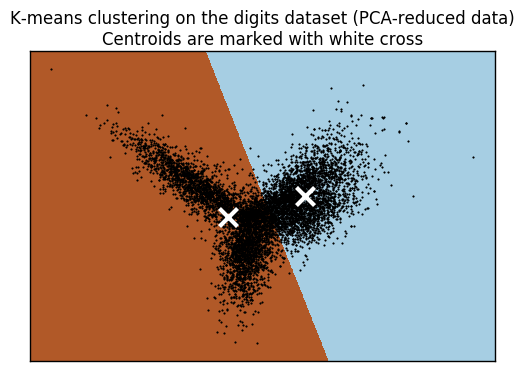

In [89]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
data = scale(all_NMF)

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Problem 5)

In [90]:
# all 20 subclasses data
total_20 = fetch_20newsgroups(subset='all', shuffle=True, random_state=42, remove=('headers','footers','quotes'))
TFxIDF_20  = TFxIDF.fit_transform(total_20.data)

In [91]:
km = KMeans(n_clusters=20, max_iter = 1000, random_state=42).fit(TFxIDF_20)

labels = total_20.target

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Adjusted_Mutual_Info_Score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

Homogeneity: 0.171
Completeness: 0.406
Adjusted Rand-Index: 0.034
Adjusted_Mutual_Info_Score: 0.169


### LSI, Truncated SVD

In [92]:
n_components = 200 #待调参数
svd = TruncatedSVD(n_components=n_components, algorithm='arpack')
total_20_LSI = svd.fit_transform(TFxIDF_20)
kmLSI = KMeans(n_clusters=20, max_iter = 1000, random_state=42).fit(total_20_LSI)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, kmLSI.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, kmLSI.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, kmLSI.labels_))
print("Adjusted_Mutual_Info_Score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, kmLSI.labels_))


Homogeneity: 0.239
Completeness: 0.335
Adjusted Rand-Index: 0.047
Adjusted_Mutual_Info_Score: 0.237


### NMF, Non-Negative Matrix Factorization

In [95]:
n_components = 1000
nmf = NMF(n_components=n_components, init = 'nndsvd', random_state=0, alpha=.1, l1_ratio=0)
total_20_NMF = nmf.fit_transform(TFxIDF_20)

kmNMF = KMeans(n_clusters=20, max_iter = 1000, random_state=42).fit(total_20_NMF)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, kmNMF.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, kmNMF.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, kmNMF.labels_))
print("Adjusted_Mutual_Info_Score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, kmNMF.labels_))

Homogeneity: 0.262
Completeness: 0.401
Adjusted Rand-Index: 0.073
Adjusted_Mutual_Info_Score: 0.259


In [ ]:
# 10 ：
#     Homogeneity: 0.218
#     Completeness: 0.274
#     Adjusted Rand-Index: 0.049
#     Adjusted_Mutual_Info_Score: 0.215

# 600 ： 
# Homogeneity: 0.263
# Completeness: 0.391
# Adjusted Rand-Index: 0.058
# Adjusted_Mutual_Info_Score: 0.260

# 1000 :
#     Homogeneity: 0.262
#     Completeness: 0.401
#     Adjusted Rand-Index: 0.073
#     Adjusted_Mutual_Info_Score: 0.259

In [115]:
# from sklearn.preprocessing import scale
# from sklearn.decomposition import PCA
# data = scale(total_20_NMF)

# reduced_data = PCA(n_components=20).fit_transform(data)
# kmeans = KMeans(init='k-means++', n_clusters=20, n_init=10)
# kmeans.fit(reduced_data)

# # Step size of the mesh. Decrease to increase the quality of the VQ.
# h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# # Plot the decision boundary. For that, we will assign a color to each
# x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
# y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# # Obtain labels for each point in mesh. Use last trained model.
# Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure(1)
# plt.clf()
# plt.imshow(Z, interpolation='nearest',
#            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Paired,
#            aspect='auto', origin='lower')

# plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# # Plot the centroids as a white X
# centroids = kmeans.cluster_centers_
# plt.scatter(centroids[:, 0], centroids[:, 1],
#             marker='x', s=169, linewidths=3,
#             color='w', zorder=10)
# plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
#           'Centroids are marked with white cross')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
# plt.show()

## Problem 6)

In [98]:
labels = total_20.target
## map class label
# print labels[0:20]
dict = {1 : 0, 2 : 0, 3 : 0, 4 : 0, 5 : 0,
        7 : 1, 8 : 1, 9 : 1, 10 : 1,
        11 : 2, 12 : 2, 13 : 2, 14 : 2,
        6 : 3,
        16 : 4, 17 : 4, 18 : 4, 
        0 : 5, 15 : 5, 19 : 5}
i = 0
for label in labels:
    labels[i] = dict[labels[i]]
    i = i+1
# print labels[0:20]

In [99]:
km = KMeans(n_clusters=6, max_iter = 1000, random_state=42).fit(TFxIDF_20)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Adjusted_Mutual_Info_Score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

Homogeneity: 0.283
Completeness: 0.132
Adjusted Rand-Index: 0.079
Adjusted_Mutual_Info_Score: 0.132


### LSI, Truncated SVD

In [105]:
n_components = 200 #待调参数
svd = TruncatedSVD(n_components=n_components, algorithm='arpack')
total_20_LSI = svd.fit_transform(TFxIDF_20)
kmLSI = KMeans(n_clusters=6, max_iter = 1000, random_state=42).fit(total_20_LSI)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, kmLSI.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, kmLSI.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, kmLSI.labels_))
print("Adjusted_Mutual_Info_Score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, kmLSI.labels_))

Homogeneity: 0.248
Completeness: 0.137
Adjusted Rand-Index: 0.098
Adjusted_Mutual_Info_Score: 0.137


In [ ]:
# 200 :
#     Homogeneity: 0.248
#     Completeness: 0.137
#     Adjusted Rand-Index: 0.098
#     Adjusted_Mutual_Info_Score: 0.137

# 500 ：
#     Homogeneity: 0.285
#     Completeness: 0.136
#     Adjusted Rand-Index: 0.096
#     Adjusted_Mutual_Info_Score: 0.136

### NMF, Non-Negative Matrix Factorization

In [114]:
n_components = 200
nmf = NMF(n_components=n_components, init = 'nndsvd', random_state=0, alpha=.1, l1_ratio=0)
total_20_NMF = nmf.fit_transform(TFxIDF_20)

kmNMF = KMeans(n_clusters=6, max_iter = 1000, random_state=42).fit(total_20_NMF)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, kmNMF.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, kmNMF.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, kmNMF.labels_))
print("Adjusted_Mutual_Info_Score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, kmNMF.labels_))

Homogeneity: 0.330
Completeness: 0.145
Adjusted Rand-Index: 0.118
Adjusted_Mutual_Info_Score: 0.145


In [ ]:
# 30:
#     Homogeneity: 0.203
#     Completeness: 0.125
#     Adjusted Rand-Index: 0.186
#     Adjusted_Mutual_Info_Score: 0.125

# 50:
#     Homogeneity: 0.249
#     Completeness: 0.124
#     Adjusted Rand-Index: 0.063
#     Adjusted_Mutual_Info_Score: 0.124

# 90
#     Homogeneity: 0.318
#     Completeness: 0.173
#     Adjusted Rand-Index: 0.239
#     Adjusted_Mutual_Info_Score: 0.173

# 200
#     Homogeneity: 0.330
#     Completeness: 0.145
#     Adjusted Rand-Index: 0.118
#     Adjusted_Mutual_Info_Score: 0.145